In [1]:
import numpy as np
from skimage.io import imread, imshow
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import copy

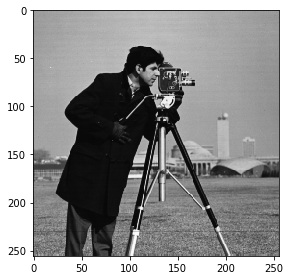

In [2]:
image = imread('cameraman.png')
#image = rgb2gray(image)
#image = resize(image, (256, 256))
imshow(image, cmap='gray')

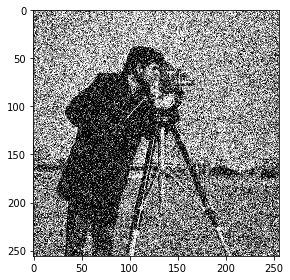

In [3]:
# Generate the noisy image:
def generate_noise(image, std):
    i = copy.deepcopy(image)
    return random_noise(i, var=np.sqrt(std))
image_noise = generate_noise(image, .01)
imshow(image_noise)

[[-0.36797381 -0.17170667  0.3272902  ...  0.08516467  0.08350337
   0.        ]
 [-0.44334458  0.06144691 -0.16141769 ... -0.78154293  0.42988743
   0.        ]
 [ 0.01172842  0.31962149 -0.22107872 ...  0.40034053 -0.80892489
   0.        ]
 ...
 [-0.96243423 -0.70287702  0.36110131 ... -0.67757484  0.61046071
   0.        ]
 [-0.54774758  0.25326126  0.05797376 ...  0.4671506  -0.05474662
   0.        ]
 [ 0.43716444  0.16483444  0.34166329 ... -0.39975659  0.08970441
   0.        ]]


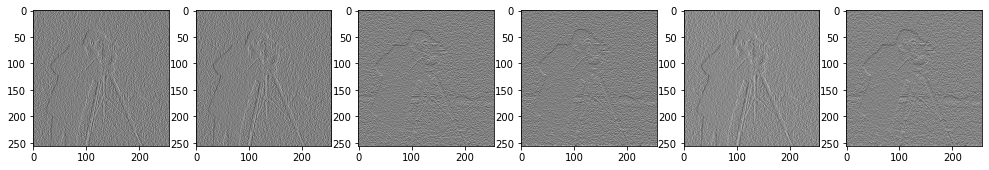

In [4]:
def fd_x(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c))
    d[:, 1:c-1] = u[:,1:c-1]-u[:, 0:c-2]
    d[:, 0] = u[:, 1]-u[:,c-1]
    return d

def fd_y(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c))
    d[1:r-1, :] = u[1:r-1, :]-u[0:r-2, :]
    d[0, :] = u[1, :]-u[r-1, :]
    return d

def bd_x(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c))
    d[:, 0:c-2] = u[:, 1:c-1] - u[:,0:c-2]
    d[:, c-1] = u[:,0] - u[:, c-1]
    return d

def bd_y(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c))
    d[0:r-2, :] = u[1:r-1, :] - u[0:r-2, :]
    d[r-1, :] = u[0, :] - u[r-1, :]
    return d

def cd_x(u):
    return (fd_x(u) + bd_x(u)) / 2

def cd_y(u):
    return (fd_y(u) + bd_y(u)) / 2

fig, ax = plt.subplots(1,6, figsize=(17, 17))
forward_x = fd_x(image_noise)
backward_x = bd_x(image_noise)
forward_y = fd_y(image_noise)
backward_y = bd_y(image_noise)
central_x = cd_x(image_noise)
central_y = cd_y(image_noise)

ax[0].imshow(forward_x, cmap='gray')
ax[1].imshow(backward_x, cmap='gray')
ax[2].imshow(forward_y, cmap='gray')
ax[3].imshow(backward_y, cmap='gray')
ax[4].imshow(central_x, cmap='gray')
ax[5].imshow(central_y, cmap='gray')


    
print(forward_x)

In [32]:
def scale(image):
    i = copy.deepcopy(image)
    high = np.max(image)
    low = np.min(image)
    i = (i-low)/(high-low)
    return i

def calc_l2(f, u, lamb):
    i = f-u
    i = i**2
    return lamb * np.sum(i)
    
    
def magnitude(i):
    return np.sqrt(np.sum(np.multiply(i, i)))


def calc_energy(f, u, lamb):
    #Part 1
    #f is noisy image, u is unknown clean desired image
    
    part1 = calc_l2(f, u, lamb)
    #Part 2 - tricky part. Going to sum central difference in x direction with central difference in y direction
    # i would initialize u as a blank noisy image
    part2 = np.mean([magnitude(cd_x(u)),  magnitude(cd_y(u))])
    return part1+part2

In [33]:
def calc_energy_gradient(f, u, lamb):
    part1 = 2 * lamb * (u - f)
    
    # add part 1, then subtract -- need to do calculations for the x and y component, then average that, 
    
    gradu_x = cd_x(u)
    v_x = gradu_x / (magnitude(gradu_x) + 1E-5)
    
    gradu_y = cd_y(u)
    v_y = gradu_y / (magnitude(gradu_y) + 1E-5)
    
    div = cd_x(v_x) + cd_y(v_y)
    
    return 2 * lamb * (u-f) - div    
    
    

In [34]:
def gradient_descent(f, u, min_iter, lamb, alpha):
    ret_image = copy.deepcopy(u)
    energy = []
    for n in range(min_iter*5):
        e = calc_energy(f, ret_image, lamb)
        energy.append(e)
        ret_image = ret_image - alpha * calc_energy_gradient(f, ret_image, lamb)
        if n % 500 == 0:
            print("Energy on iteration ", n, ": ", e, end='\r')
        if np.mean(abs(np.diff(energy[-1000:]))) < .01 and n > min_iter:
            break
    
    #scale
    ret_image = scale(ret_image)
            
    return ret_image, energy
        

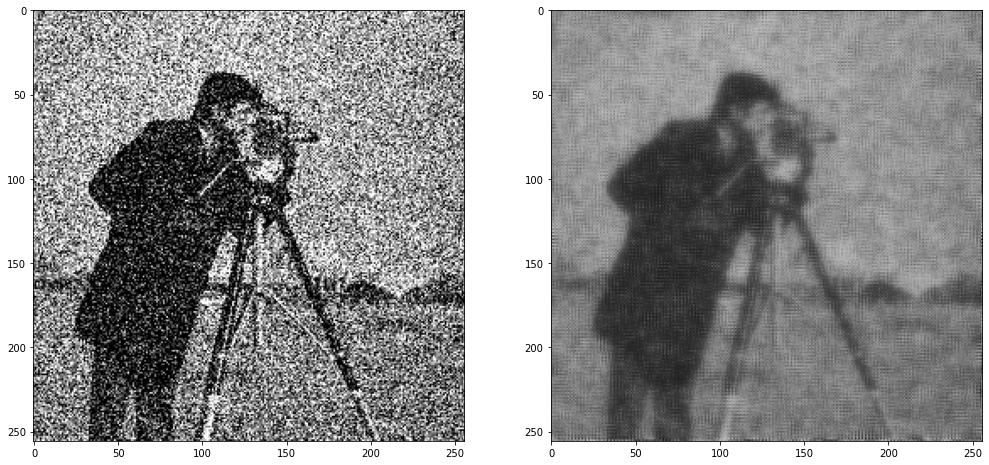

In [35]:
blank_noise = np.full((256, 256), .5)
image_noise = generate_noise(image, .01)

smoothed_image_slow, energies_slow = gradient_descent(image_noise, blank_noise, 10000, .01, .04)



fig, ax = plt.subplots(1,2, figsize=(17, 17))
ax[0].imshow(image_noise, cmap='gray')
ax[1].imshow(smoothed_image_slow, cmap='gray')

Text(0, 0.5, 'Energy')

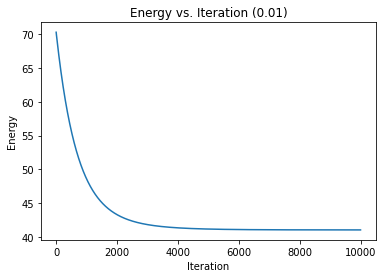

In [37]:
plt.plot(energies_slow)
plt.title("Energy vs. Iteration (0.01)")
plt.xlabel("Iteration")
plt.ylabel("Energy")